# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score, precision_score, recall_score, precision_recall_fscore_support, fbeta_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, make_scorer
from sklearn.inspection import permutation_importance

from scipy import stats

from PipelineObjects import *

In [2]:
# This sets the logging level for custom transformers defined in PipelineObjects
set_log_level(logging.WARN)

# Import Data

In [3]:
# Read in file while dropping the ones without a 'Make' field to reduce memory footprint
file = 'data.csv'

# df_raw = pd.DataFrame()
# with pd.read_csv(file, chunksize=1000000) as chunks:
#   for chunk in chunks:
#     chunk.dropna(axis=0, subset=['Make'], inplace=True) # Dropping all rows with any NaN value
#     df_raw = pd.concat([df_raw, chunk])
# del chunks

# For shorter tests, get only a small number of rows
df_raw = pd.read_csv(file, nrows=50000)
df_raw.dropna(subset='Make', inplace=True)

# This is used to get a continuous index on the raw dataframe
df_raw.reset_index(inplace=True, drop=True)

print(f'# Records: {len(df_raw)}')

# Records: 24961


In [41]:
dd = {'Color':'BK', 'BodyStyle': 'PA', 'StatePlate': 'CA'}
dft = pd.DataFrame(dd,index=['i',])

pipe.predict_proba(dft)[0,1]

0.9148305943766679

## Set up target

1.0    0.916029
0.0    0.083971
Name: top25, dtype: float64


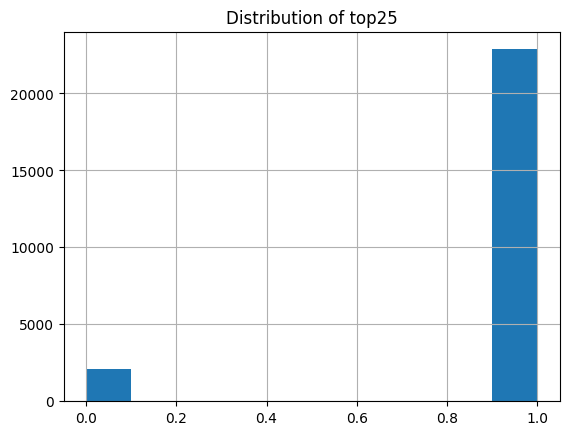

In [4]:
# Get set of top 25 manufacturers
top25 = set(df_raw['Make'].value_counts(dropna=True, ascending=False)[:25].index.to_list())

# If Make is in top 25 manufacturers, then set top25 to 1, else 0
cond = df_raw['Make'].isin(top25)
df_raw.loc[cond, 'top25'] = 1
df_raw.loc[~cond, 'top25'] = 0

# See distribution of top25
print(df_raw['top25'].value_counts(dropna=False)/len(df_raw))
plt.hist(x=df_raw['top25'])
plt.grid()
plt.title('Distribution of top25')
plt.show()

## Rename Columns

In [5]:
# Columns are renamed for better readability
col_rename = {
  'Ticket number': 'TicketNum',
  'Issue Date': 'IssueDate',
  'Issue time': 'IssueTime', 
  'Meter Id': 'MeterID', 
  'Marked Time': 'MarkedTime',
  'RP State Plate': 'StatePlate', 
  'Plate Expiry Date': 'PlateExpiration', 
  'Body Style': 'BodyStyle',
  'Violation code': 'ViolationCode',
  'Violation Description': 'ViolationDesc',
  'Fine amount': 'Fine',
}
df_raw.rename(columns=col_rename, inplace=True)

# set issue date as datetime type
df_raw['IssueDate'] = df_raw['IssueDate'].astype('datetime64[ns]')

## Drop identifier columns

In [6]:
to_drop = ['VIN', 'TicketNum']
df_raw.drop(columns=to_drop, inplace=True)

# Data Exploration

## Generic Properties

First 5 rows

In [7]:
df_raw.head()

,IssueDate,IssueTime,MeterID,MarkedTime,StatePlate,PlateExpiration,Make,BodyStyle,Color,Location,Route,Agency,ViolationCode,ViolationDesc,Fine,Latitude,Longitude,top25
0,2015-09-15,115.0,NaN,NaN,CA,200316.0,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,1.0
1,2015-12-17,1710.0,NaN,NaN,CA,201605.0,MAZD,PA,BL,SUNSET/ALVARADO,00217,1.0,8070,PARK IN GRID LOCK ZN,163.0,99999.0,99999.0,1.0
2,2015-12-22,1100.0,NaN,NaN,CA,201511.0,FORD,TR,WH,1159 HUNTLEY DR,2A75,1.0,8069AA,NO STOP/STAND AM,93.0,99999.0,99999.0,1.0
3,2015-12-22,1105.0,NaN,NaN,CA,201701.0,CHRY,PA,GO,1159 HUNTLEY DR,2A75,1.0,8069AA,NO STOP/STAND AM,93.0,99999.0,99999.0,1.0
4,2015-12-27,1055.0,NaN,NaN,CA,201605.0,TOYO,PA,BK,3100 N HOLLYRIDGE DR,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0,1.0


Description

In [8]:
df_raw.describe()

,IssueTime,MarkedTime,PlateExpiration,Agency,Fine,Latitude,Longitude,top25
count,24956.000000,601.000000,22938.000000,24960.000000,24923.000000,2.496100e+04,2.496100e+04,24961.000000
mean,1229.530975,1090.795341,184600.679135,51.271755,71.875456,4.910879e+06,1.424294e+06,0.916029
std,456.145911,233.185269,55999.312442,11.018892,37.233079,2.726010e+06,7.507280e+05,0.277350
min,1.000000,225.000000,1.000000,1.000000,25.000000,9.999900e+04,9.999900e+04,0.000000
25%,919.000000,925.000000,201512.000000,51.000000,63.000000,6.380617e+06,1.747046e+06,1.000000
50%,1204.000000,1042.000000,201604.000000,54.000000,68.000000,6.443232e+06,1.839906e+06,1.000000
75%,1545.250000,1230.000000,201608.000000,55.000000,73.000000,6.472358e+06,1.855566e+06,1.000000
max,2359.000000,2236.000000,209009.000000,58.000000,363.000000,6.512578e+06,1.940396e+06,1.000000


Data types

In [9]:
df_raw.dtypes

IssueDate          datetime64[ns]
IssueTime                 float64
MeterID                    object
MarkedTime                float64
StatePlate                 object
PlateExpiration           float64
Make                       object
BodyStyle                  object
Color                      object
Location                   object
Route                      object
Agency                    float64
ViolationCode              object
ViolationDesc              object
Fine                      float64
Latitude                  float64
Longitude                 float64
top25                     float64
dtype: object

Missing values

In [10]:

# Get the percentage of each column that is missing (sorted in descending order)
missing = df_raw.isna().mean().sort_values(ascending=False)
cond = missing != 0
missing[cond]

MarkedTime         0.975922
MeterID            0.730419
PlateExpiration    0.081046
Route              0.011378
Fine               0.001522
BodyStyle          0.000881
Color              0.000521
IssueTime          0.000200
ViolationDesc      0.000120
Agency             0.000040
dtype: float64

In [11]:
# Drop MarkedTime since over 95% of it is missing anyway
df_raw.drop(columns=['MarkedTime'], inplace=True)

Correlations

<AxesSubplot:>

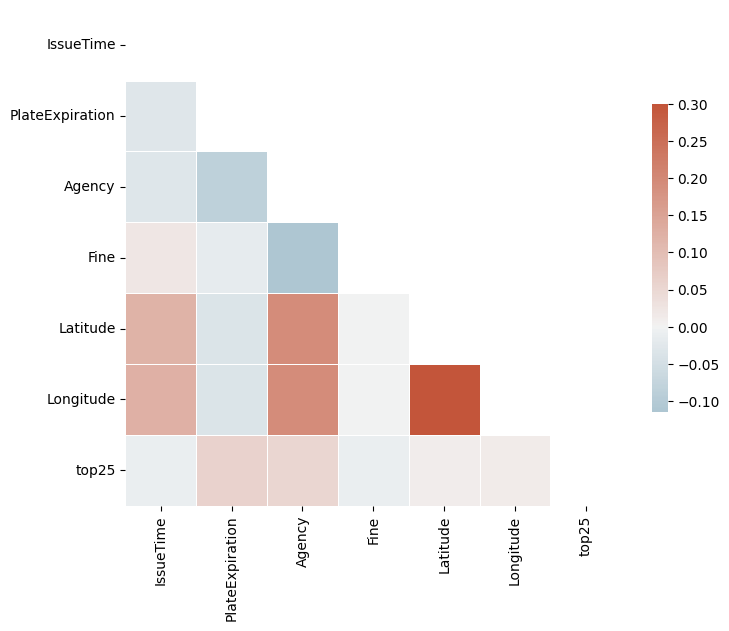

In [12]:
# Get correations
corr = df_raw.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Features

The features `['BodyStyle', 'Color', 'StatePlate']` seem most promising as shown below

### Categorical

In [13]:
# Check dimensionality for each categorical variable. This is useful to see which features are too fragmented for OHE
for _ in df_raw.select_dtypes(exclude=['float', 'int']).columns:
  print(f'{_}: {len(df_raw[_].value_counts(dropna=False))}')

IssueDate: 63
MeterID: 4461
StatePlate: 61
Make: 110
BodyStyle: 22
Color: 32
Location: 18741
Route: 620
ViolationCode: 115
ViolationDesc: 114


In [14]:
# Exploring the StatePlate feature since that is higher than expected:
# copied list of state codes from from https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
# These frequencies are low enough and will be taken care of by the aggregation.

states = set(['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VT','VA','VI','WA','WV','WI','WY'])

ll = df_raw['StatePlate'].value_counts(dropna=False)
for i, v in ll.iteritems():
  if i not in states:
    print(i, v)

MX 8
BC 5
AB 5
QU 2
NB 1
ON 1
CN 1
US 1
CZ 1
XX 1
SA 1


In [15]:
# Applying the category aggregator to the features of interest has the following effect in terms of reducing the cardinality:
aggregators = {
  'BodyStyle': CategoryAggregator(cols=['BodyStyle'], threshold=0.95, convert_num=False),
  'Color': CategoryAggregator(cols=['Color'], threshold=0.85, convert_num=False),
  'StatePlate': CategoryAggregator(cols=['StatePlate'], threshold=0.96, convert_num=False),
}

for col, agg in aggregators.items():
  print(col)
  print(agg.fit_transform(df_raw[[col]]).value_counts(dropna=False))
  print('---')

BodyStyle
BodyStyle
PA           21909
Other         1516
PU             817
VN             719
dtype: int64
---
Color
Color
BK       5249
WT       4969
GY       4904
Other    4742
SL       3172
BL       1925
dtype: int64
---
StatePlate
StatePlate
CA            23415
Other          1031
AZ              214
TX              153
NV              148
dtype: int64
---


### Numerical

IssueTime


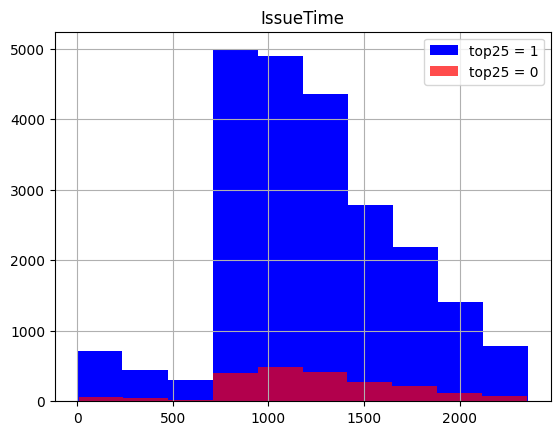

PlateExpiration


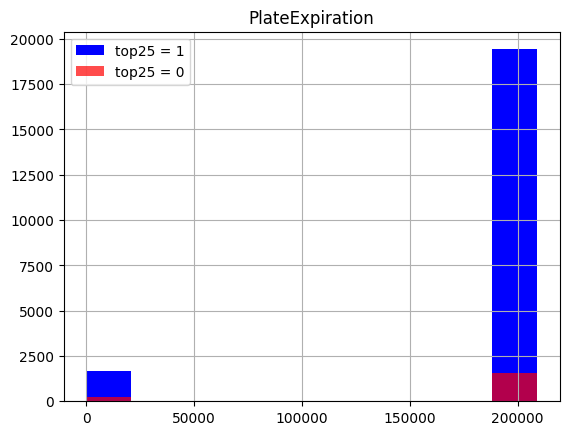

Agency


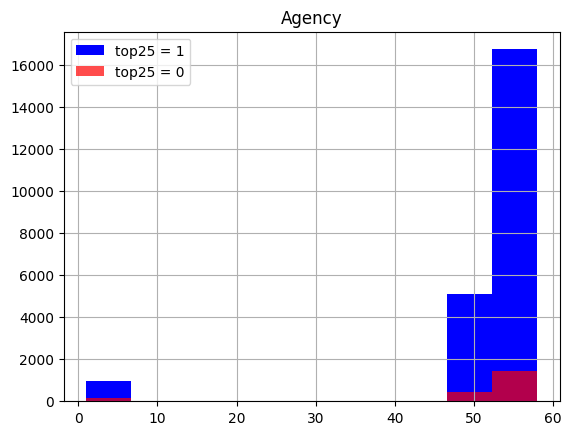

Fine


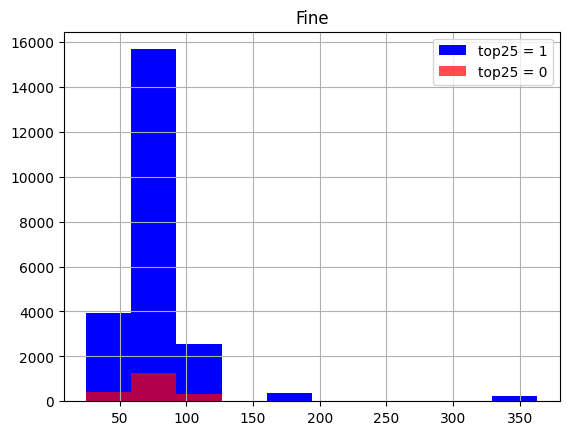

Latitude


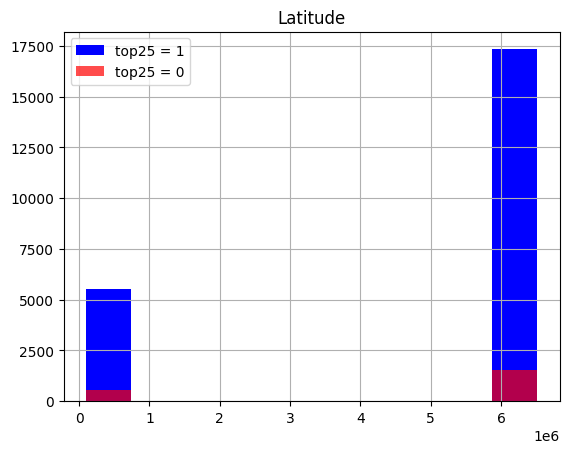

Longitude


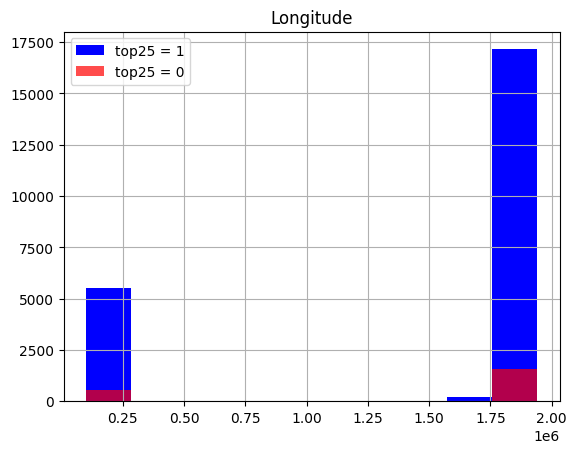

top25


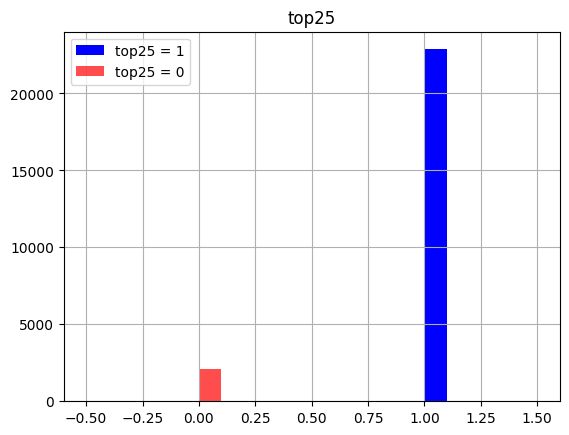

In [16]:
for _ in df_raw.select_dtypes(include=['float', 'int']).columns:
  cond = df_raw['top25'] == 1
  print(_)
  plt.hist(x=df_raw[cond][_], color='blue', alpha=1.0, label='top25 = 1')
  plt.hist(x=df_raw[~cond][_], color='red', alpha=0.7, label='top25 = 0')
  plt.title(_)
  plt.grid()
  plt.legend()
  plt.show()

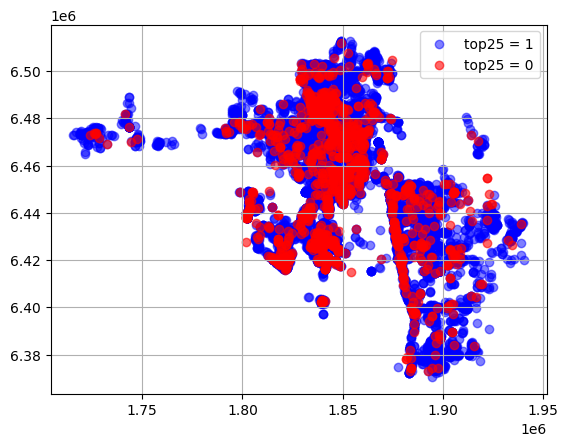

In [17]:
# There does not seem to be any correlation between top25 and Latitude / Longitude

# There are a number of outliers that affect the scale of the plot. The condition below only selects records that are within a certain number of standard deviations from the mean.
cond = (
  (abs(stats.zscore(df_raw['Latitude'], nan_policy='omit')) < 1.2) & 
  (abs(stats.zscore(df_raw['Longitude'], nan_policy='omit')) < 1.2)
)

cond0 = df_raw['top25'] == 0
cond1 = df_raw['top25'] == 1

plt.scatter(df_raw[cond & cond1]['Longitude'], df_raw[cond & cond1]['Latitude'], color='blue', label='top25 = 1', alpha=0.5)
plt.scatter(df_raw[cond & cond0]['Longitude'], df_raw[cond & cond0]['Latitude'], color='red', label='top25 = 0', alpha=0.6)
plt.legend()
plt.grid()
plt.show()


# Modeling

## Set up training / test set and input features

In [18]:
# input_features = ['BodyStyle', 'Color', 'StatePlate', 'PlateExpiration'] # 0.6629
input_features = ['BodyStyle', 'Color', 'StatePlate'] #0.6524

X = df_raw[input_features].copy()
y = df_raw['top25'].copy()

# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

## Set up pipeline

Some custom transformers (defined in `./PipelineObjects.py`) are used here.

In [19]:
# A feature selector lets the user have an arbitrary input, the model only picks up the features it needs
feature_selector = FeatureSelector(features=input_features)

# This aggregates the values in a given column as 'other' once the given threshold is met. The convert_num flag is used to convert a given category to a numerical value (frequency )
# Some testing is done to get the threshold so the aggregate categories have 4-6 unique values
agg_body = CategoryAggregator(cols=['BodyStyle'], threshold=0.95, convert_num=False)
agg_color = CategoryAggregator(cols=['Color'], threshold=0.85, convert_num=False)
agg_state = CategoryAggregator(cols=['StatePlate'], threshold=0.96, convert_num=False)


# Set up generic numeric and categorical transformers for imputation, scaling, and OHE
numeric_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
  ]
)

categorical_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(sparse=False, handle_unknown="ignore", drop='if_binary')),
  ]
)

final_transformer = ColumnTransformer(
  [
    # final transformations            
    ("numerical", numeric_transformer, make_column_selector(dtype_include=['float', 'int'])),
    ("categorical", categorical_transformer, make_column_selector(dtype_include=['category'])),

  ],
  remainder="passthrough",
)

# Set up model
model = RandomForestClassifier( 
  n_estimators=100,
  min_samples_leaf=15,
  max_features="sqrt",
  n_jobs=-1,
  random_state=42
)

# model = LogisticRegression(
#   penalty='l2',
#   C=0.01,
#   random_state=42
# )


# Combine all transformers and model into a pipeline
pipe = Pipeline(
  [
    ('feature_selector', feature_selector),
    ('agg_body',agg_body), 
    ('agg_color',agg_color), 
    ('agg_state',agg_state), 
    ('final_transformer', final_transformer),
    ('model', model)
  ]
)

## Fit Pipeline

In [20]:
sample_size = len(X_train)
pipe.fit(X_train[:sample_size], y_train[:sample_size])

Pipeline(steps=[('feature_selector',
                 FeatureSelector(features=['BodyStyle', 'Color',
                                           'StatePlate'])),
                ('agg_body', CategoryAggregator(cols=['BodyStyle'])),
                ('agg_color',
                 CategoryAggregator(cols=['Color'], threshold=0.85)),
                ('agg_state',
                 CategoryAggregator(cols=['StatePlate'], threshold=0.96)),
                ('final_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   tran...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a9a0a0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125a9a1c0>)])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=15, n_jobs=-1,
                                        random_state=42))])

# Metrics

In [21]:
metrics = {}
y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

## ROC

ROC AUC: 0.6362


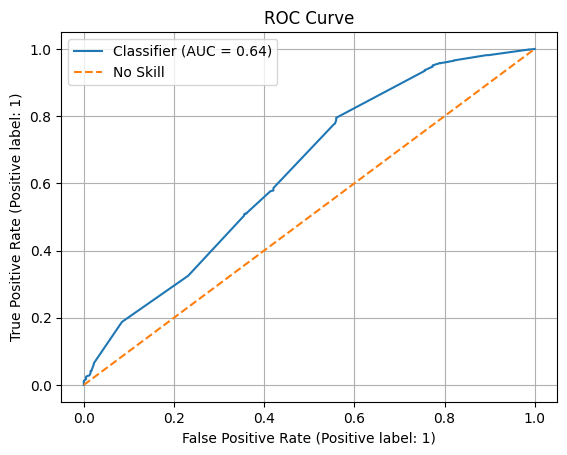

In [22]:
metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {metrics['roc_auc']:0.4f}")

RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title(f'ROC Curve')
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.legend()
plt.grid()
plt.savefig('ROC.png')
plt.show()

## Precision Recall

ROC AUC: 0.9442


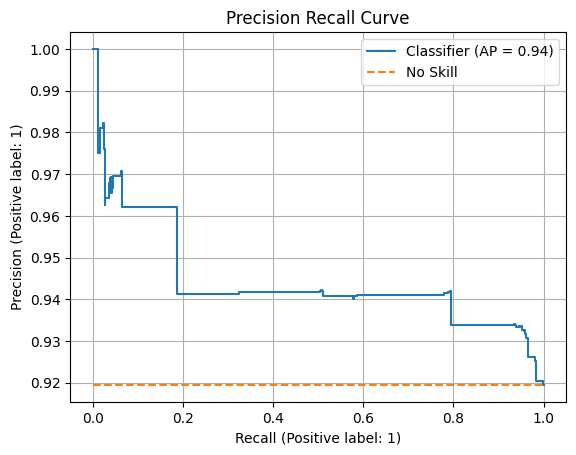

In [23]:
metrics['avg_prec'] = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC: {metrics['avg_prec']:0.4f}")

baseline=np.sum(y_test==1)/len(y_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title(f'Precision Recall Curve')
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='No Skill')
plt.legend()
plt.grid()
plt.savefig('PrecisionRecall.png')
plt.show()

## Accuracy

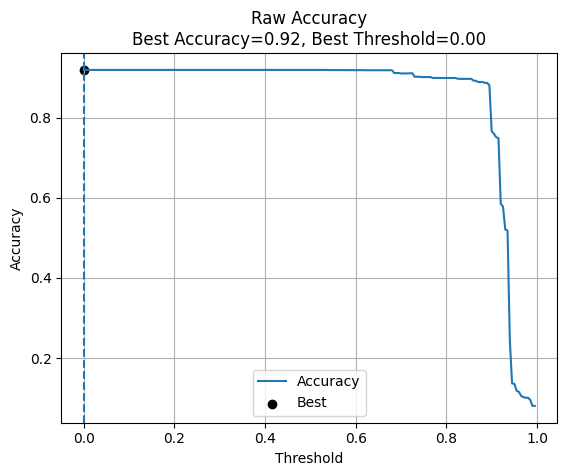

In [24]:
thresholds = np.arange(0, 1, 0.005)
accuracies = [accuracy_score(y_test, y_pred_proba > t) for t in thresholds]
idx = np.argmax(accuracies)
optimal_threshold = thresholds[idx]
optimal_metric = accuracies[idx]
plt.plot(thresholds, accuracies, label='Accuracy')
plt.title(f'Raw Accuracy\nBest Accuracy={optimal_metric:0.2f}, Best Threshold={optimal_threshold:0.2f}')
plt.scatter(optimal_threshold, optimal_metric, label=f'Best', color='black')
plt.axvline(optimal_threshold, linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

## Confusion Matrix

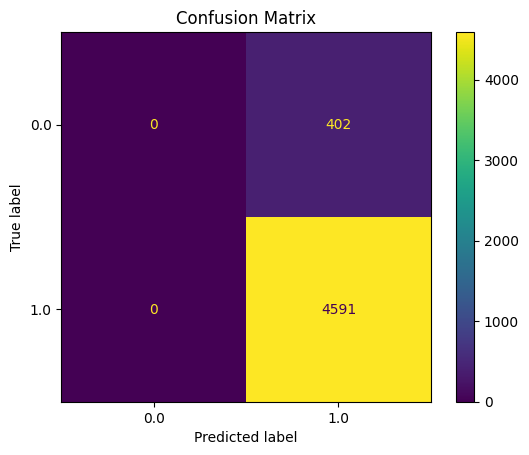

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Confusion Matrix')
plt.savefig('ConfusionMatrix.png')
plt.show()

## Feature Importances

In [26]:
def get_col_names(X, pipe):
  X_ = X.copy()
  # assumes final_transformer and then model are the last two steps
  for i in range(len(pipe)-2):
    X_ = pipe[i].transform(X_)

  # select the cols that will be input to the OHE and use get_feature_names_out to transform them to the ohe encoded versions
  cat_cols = X_.select_dtypes(exclude=['float', 'int']).columns
  ohe_cols = pipe.named_steps['final_transformer'].named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(cat_cols)

  # get the full list of columns (numeric and ohe-encoded)
  full_list = X_.select_dtypes(include=['float', 'int']).columns.to_list()+list(ohe_cols)
  return full_list

feature_names = get_col_names(X, pipe)

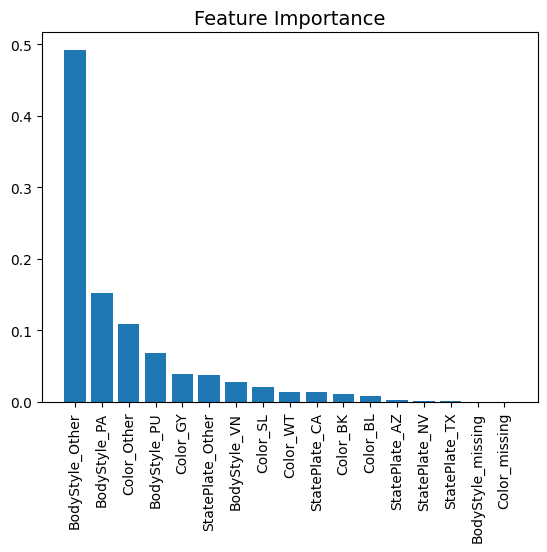

In [27]:
# importances = pipe['model'].coef_[0]
importances = pipe['model'].feature_importances_
sorted_idx = (-abs(importances)).argsort()
feature_imp_df = pd.DataFrame({'features': np.array(feature_names)[sorted_idx], 'importances': importances[sorted_idx]}, feature_names)
plt.xticks(rotation='vertical')
plt.title('Feature Importance', fontsize=14)
plt.bar(feature_imp_df.features, feature_imp_df.importances)
plt.savefig('FeatureImportance.png')


## Metrics Summary

In [28]:
pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

,Value
roc_auc,0.636181
avg_prec,0.944211


# Save Model

In [29]:
file = 'model.pkl'
pickle.dump(pipe, open(file, 'wb'))